In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
import logging
import colorcet as cc
from matplotlib.ticker import ScalarFormatter

logging.getLogger('matplotlib.pyplot').setLevel(logging.WARNING)

logger = logging.getLogger('Plots_Log')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

# Palette and markers

In [3]:
pivots = ["BPP", "CONVEX", "FFT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
palette = sns.color_palette(cc.glasbey, n_colors=12)
palette_pivots = dict(zip(pivots, palette))
markers = ["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"]

# Read dataframe

In [4]:
def read_data(basePath: str, index: str, dataset: str, pivot: str, idx: int = 0) -> pd.DataFrame:
    
    if basePath is None:
        logger.error("Empty path")
    
    plot_folder = join(basePath, index.upper() + '_' + dataset.upper() + '_' + pivot.upper() + '_' + str(idx))
    
    if not isdir(plot_folder):
        logger.error("Directory does not exist")
        
    experimentsFiles = [join(plot_folder, f) for f in listdir(plot_folder) if 'experiment' in f]
    
    data = pd.DataFrame()
    
    for exptFile in experimentsFiles:
        aux = pd.read_csv(exptFile)
        data = pd.concat([data, aux], ignore_index=True)
    
    logger.info(f' Number of lines read: {data.shape[0]}')
    
    return data

# Individual plots

In [10]:
def plot_distance(basePath: str, index: str, dataset: str, pivot: str, agg: str = 'mean', idx: int = 0) -> None:
    
    if agg != 'mean' and agg != 'median':
        logger.critical("Unsupported aggregation method")
    
    data = read_data(basePath, index, dataset, pivot, idx) 
    data = data.drop(['expt_id', 'r', 'time', 'sys_time', 'user_time', 'prunning', 'iowrite', 'ioread'], axis=1)
    data['k'] = pd.to_numeric(data['k'])
    data['distCount'] = pd.to_numeric(data['distCount'])
    k_range = list(range(data['k'].unique().min(), data['k'].unique().max()+1, 5))
    rows_list = []
    
    for k in k_range:
        aux_data = data[data['k'] == k]
        rows_list.append({'k': k, 'distCount': aux_data.agg({'distCount': agg}).iloc[0]})
        
    data_agg = pd.DataFrame(rows_list)

    plt = sns.lineplot(data=data_agg, x='k', y='distCount')
    plt.set(xlabel='K')
    plt.set(ylabel='Number of distance computations')
    xticksList = [5, 50, 100]
    plt.set(xticks=xticksList)
    plt.set_xticklabels(xticksList)
    plt.set(xlim=(5,100))
    ax = plt.axes
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    

/home/joaoleite/anaconda3/envs/gervLib_py_scripts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/joaoleite/anaconda3/envs/gervLib_py_scripts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/joaoleite/anaconda3/envs/gervLib_py_scripts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/joaoleite/anaconda3/envs/gervLib_py_scripts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

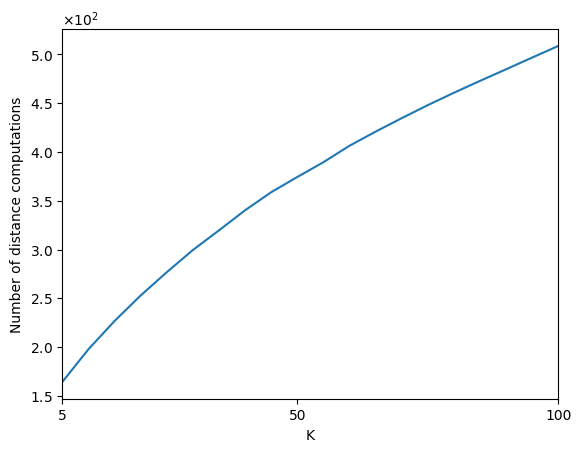

In [11]:
plot_distance(basePath='output_files', index='lc', dataset='cities', pivot='bpp', agg='mean')